In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

Implémentation de environnement LineWorld

In [ ]:
class LineWorld:
    def __init__(self, length=5):
        self.length = length
        self.start_state = 0
        self.end_state = length - 1
        self.reset()

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        # 0 = gauche, 1 = droite
        if action == 0:
            self.state = max(0, self.state - 1)
        elif action == 1:
            self.state = min(self.length - 1, self.state + 1)

        reward = 1 if self.state == self.end_state else 0
        done = self.state == self.end_state
        return self.state, reward, done, {}

    def get_valid_actions(self):
        return [0, 1]


Lancement des Agents test sur l'environnement LinWorld :

Agent Random

In [ ]:
import random

def run_random_agent(env, episodes=1000):
    total_rewards = []
    total_steps = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action = random.choice(env.get_valid_actions())
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = sum(total_rewards) / episodes
    avg_steps = sum(total_steps) / episodes
    print(f"Random Agent on LineWorld ({env.length} states)")
    print(f"Average reward: {avg_reward:.2f}")
    print(f"Average episode length: {avg_steps:.2f} steps")

if __name__ == "__main__":
    env = LineWorld(length=5)
    run_random_agent(env)


Agent TabularQLearning

In [ ]:
import random
from collections import defaultdict

class TabularQLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.9):
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        q_predict = self.q_table[state][action]
        q_target = reward if done else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

In [ ]:
def trainTabularQLearningAgent(env, episodes=1000):
    agent = TabularQLearningAgent(n_states=env.length, n_actions=2)
    total_rewards = []
    total_steps = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    
        if (episode + 1) % 50 == 0:
            avg_last_50 = np.mean(total_rewards[-50:])
            print(f"Épisode {episode+1}/{episodes} - Moyenne des 50 derniers épisodes : {avg_last_50:.3f}")

    return agent, total_rewards, total_steps

def evaluateTabularQLearningPolicy(agent, env, episodes=100):
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    total_rewards = []
    total_steps = []
    action_times = []

    for _ in range(episodes):
        state = env.reset()
        done = False
        reward_sum = 0
        steps = 0

        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            steps += 1

        total_rewards.append(reward_sum)
        total_steps.append(steps)

    agent.epsilon = original_epsilon  # restaurer

    print("\n Évaluation de la policy finale (ε = 0) :")
    print(f"  - Score moyen : {np.mean(total_rewards):.3f}")
    print(f"  - Longueur moyenne : {np.mean(total_steps):.2f} steps")
    print(f"  - Temps moyen par action : {np.mean(action_times) * 1000:.3f} ms")


In [ ]:
def plot_rewards(rewards, title="Rewards par episodes"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward par épisode")
    plt.plot(np.convolve(rewards, np.ones(50)/50, mode="valid"), color="orange")
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()


if __name__ == "__main__":
    env = LineWorld(length=5)
    agent, total_rewards, total_steps = trainTabularQLearningAgent(env, episodes=10000)
    plot_rewards(total_rewards, title="Tabular Q-Learning sur LineWorld")
    evaluateTabularQLearningPolicy(agent, env, episodes=100)



Agent DeepQLearning

In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, n_actions, gamma=0.8, epsilon=0.99, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.model = DQNNetwork(state_dim, n_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        with torch.no_grad():
            # state_tensor = torch.FloatTensor([state])
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def learn(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        done_tensor = torch.tensor(done, dtype=torch.float32)

        q_values = self.model(state_tensor)
        next_q_values = self.model(next_state_tensor)

        target = reward_tensor if done else reward_tensor + self.gamma * torch.max(next_q_values).detach()

        loss = self.criterion(q_values[0][action], target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
def train_dqn(agent, env, episodes=1000):
    rewards_per_episode = []
    steps_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done:
            action = agent.select_action([state])
            next_state, reward, done, _ = env.step(action)
            agent.learn([state], action, reward, [next_state], done)
            state = next_state
            total_reward += reward
            steps += 1

        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_per_episode[-50:])
            print(f"Épisode {episode+1}/{episodes} - Moyenne des 50 derniers épisodes : Récompense = {avg_reward:.3f}")

    avg_steps_final = np.mean(steps_per_episode)
    print(f"\nNombre moyen de steps par épisode à la fin de l'entraînement : {avg_steps_final:.2f}")

    return rewards_per_episode

def evaluate_policy(agent, env, n_eval_episodes=100, epsilon_eval=0.0):
    original_epsilon = agent.epsilon
    agent.epsilon = epsilon_eval

    total_rewards = []
    total_steps = []
    action_times = []

    for _ in range(n_eval_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        ep_steps = 0

        while not done:
            start = time.time()
            action = agent.select_action([state])
            action_times.append(time.time() - start)

            state, reward, done, _ = env.step(action)
            ep_reward += reward
            ep_steps += 1

        total_rewards.append(ep_reward)
        total_steps.append(ep_steps)

    agent.epsilon = original_epsilon

    print(f"\n Évaluation sur {n_eval_episodes} épisodes avec ε=0 :")
    print(f"  - Score moyen final : {np.mean(total_rewards):.2f}")
    print(f"  - Longueur moyenne : {np.mean(total_steps):.2f} steps")
    print(f"  - Temps moyen par action : {np.mean(action_times) * 1000:.3f} ms")

In [ ]:
def plot_rewards(rewards, title="Récompense par épisode"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Reward par épisode')
    plt.plot(
        np.convolve(rewards, np.ones(50)/50, mode='valid'),
        label='Reward moyenne (fenêtre=50)', color='orange'
    )
    plt.xlabel('Épisodes')
    plt.ylabel('Récompense')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    env = LineWorld(length=5)
    agent = DQNAgent(state_dim=1, n_actions=2)
    rewards = train_dqn(agent, env, episodes=1000)
    plot_rewards(rewards, title="DQN sur LineWorld")

    evaluate_policy(agent, env, n_eval_episodes=100)  




Agent DoubleDeepQLearning

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class DoubleDQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DoubleDQNAgent:
    def __init__(self, state_dim, n_actions, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.policy_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.update_counter = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        with torch.no_grad():
            state_tensor = torch.tensor([state], dtype=torch.float32).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            return torch.argmax(q_values).item()

    def learn(self, state, action, reward, next_state, done):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)


        current_q = self.policy_net(state_tensor)[0][action]

        with torch.no_grad():
            next_action = torch.argmax(self.policy_net(next_state_tensor), dim=1)
            next_q = self.target_net(next_state_tensor)[0][next_action]
            target_q = reward_tensor if done else reward_tensor + self.gamma * next_q

        loss = self.criterion(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_counter += 1
        if self.update_counter % 10 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


In [154]:
def trainDoubleDQNAgent(env, agent, episodes=1000):
    total_rewards = []
    total_steps = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0

        while not done:
            action = agent.select_action([state])
            next_state, reward, done, _ = env.step(action)
            agent.learn([state], action, reward, [next_state], done)
            state = next_state
            ep_reward += reward
            steps += 1

        total_rewards.append(ep_reward)
        total_steps.append(steps)

        if (episode + 1) % 50 == 0:
            print(f"Épisode {episode + 1}/{episodes} - Moyenne des 50 derniers : {np.mean(total_rewards[-50:]):.3f}")

    return agent, total_rewards, total_steps

def evaluateDoubleDQNPolicy(agent, env, episodes=100):
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    total_rewards = []
    total_steps = []
    action_times = []

    for _ in range(episodes):
        state = env.reset()
        done = False
        reward_sum = 0
        steps = 0

        while not done:
            start = time.time()
            action = agent.select_action([state])
            action_times.append(time.time() - start)
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            steps += 1

        total_rewards.append(reward_sum)
        total_steps.append(steps)

    agent.epsilon = original_epsilon

    print("\n Évaluation de la policy finale (ε = 0) :")
    print(f"  - Score moyen : {np.mean(total_rewards):.3f}")
    print(f"  - Longueur moyenne : {np.mean(total_steps):.2f} steps")
    print(f"  - Temps moyen par action : {np.mean(action_times) * 1000:.3f} ms")


Épisode 50/10000 - Moyenne des 50 derniers : 1.000
Épisode 100/10000 - Moyenne des 50 derniers : 1.000
Épisode 150/10000 - Moyenne des 50 derniers : 1.000
Épisode 200/10000 - Moyenne des 50 derniers : 1.000
Épisode 250/10000 - Moyenne des 50 derniers : 1.000
Épisode 300/10000 - Moyenne des 50 derniers : 1.000
Épisode 350/10000 - Moyenne des 50 derniers : 1.000
Épisode 400/10000 - Moyenne des 50 derniers : 1.000
Épisode 450/10000 - Moyenne des 50 derniers : 1.000
Épisode 500/10000 - Moyenne des 50 derniers : 1.000
Épisode 550/10000 - Moyenne des 50 derniers : 1.000
Épisode 600/10000 - Moyenne des 50 derniers : 1.000
Épisode 650/10000 - Moyenne des 50 derniers : 1.000
Épisode 700/10000 - Moyenne des 50 derniers : 1.000
Épisode 750/10000 - Moyenne des 50 derniers : 1.000
Épisode 800/10000 - Moyenne des 50 derniers : 1.000
Épisode 850/10000 - Moyenne des 50 derniers : 1.000
Épisode 900/10000 - Moyenne des 50 derniers : 1.000
Épisode 950/10000 - Moyenne des 50 derniers : 1.000
Épisode 1000/

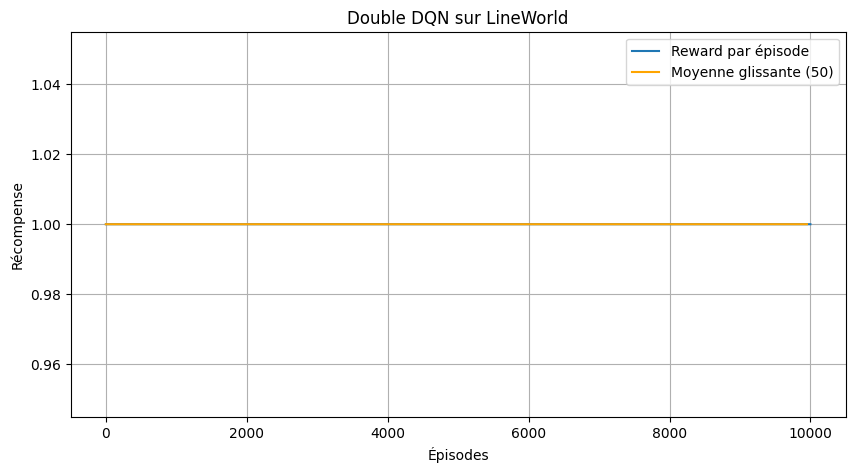


 Évaluation de la policy finale (ε = 0) :
  - Score moyen : 1.000
  - Longueur moyenne : 4.00 steps
  - Temps moyen par action : 0.043 ms


In [ ]:
def plot_rewards(rewards, title="Double DQN - Rewards over episodes"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward par épisode")
    plt.plot(np.convolve(rewards, np.ones(50)/50, mode="valid"),
             label="Moyenne glissante (50)", color="orange")
    plt.title(title)
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense")
    plt.legend()
    plt.grid()
    plt.show()

env = LineWorld(length=5)
agent = DoubleDQNAgent(state_dim=1, n_actions=2)

agent, rewards, steps = trainDoubleDQNAgent(env, agent, episodes=1000)
plot_rewards(rewards, title="Double DQN sur LineWorld")
evaluateDoubleDQNPolicy(agent, env, episodes=100)


Agent DoubleDeepQLearningWithExperienceReplay :

Buffer

In [ ]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


DDQL ER

In [ ]:
class DoubleDQNWithReplayAgent:
    def __init__(self, state_dim, n_actions, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3, buffer_size=10000, batch_size=64):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.policy_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.memory = ReplayBuffer(capacity=buffer_size)
        self.update_counter = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        with torch.no_grad():
            state_tensor = torch.FloatTensor([state])
            q_values = self.policy_net(state_tensor)
            return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_actions = torch.argmax(self.policy_net(next_states), dim=1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + self.gamma * next_q * (1 - dones)

        loss = self.criterion(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_counter += 1
        if self.update_counter % 10 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


Agent DoubleDeepQLearningWithPrioritizedExperienceReplay

Buffer

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.alpha = alpha
        self.pos = 0

    def add(self, state, action, reward, next_state, done, td_error=1.0):
        priority = (abs(td_error) + 1e-5) ** self.alpha
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
            self.priorities[self.pos] = priority
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        probs = np.array(self.priorities) / sum(self.priorities)
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]
        return samples

    def __len__(self):
        return len(self.buffer)


DDQLPER

In [ ]:
class DoubleDQNWithPrioritizedReplayAgent:
    def __init__(self, state_dim, n_actions, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3, buffer_size=10000, batch_size=64):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.policy_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net = DoubleDQNNetwork(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.memory = PrioritizedReplayBuffer(capacity=buffer_size)
        self.update_counter = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        with torch.no_grad():
            state_tensor = torch.FloatTensor([state])
            q_values = self.policy_net(state_tensor)
            return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        with torch.no_grad():
            s_tensor = torch.FloatTensor([state])
            ns_tensor = torch.FloatTensor([next_state])
            q_val = self.policy_net(s_tensor)[0][action]
            next_action = torch.argmax(self.policy_net(ns_tensor)).item()
            next_q = self.target_net(ns_tensor)[0][next_action]
            target = reward + self.gamma * next_q * (1 - int(done))
            td_error = abs(q_val.item() - target.item())

        self.memory.add(state, action, reward, next_state, done, td_error)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_actions = torch.argmax(self.policy_net(next_states), dim=1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            targets = rewards + self.gamma * next_q * (1 - dones)

        loss = self.criterion(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_counter += 1
        if self.update_counter % 10 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


REINFORCE

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)
    
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-2):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.trajectory = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor([state])
        probs = self.policy(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        self.trajectory.append((state_tensor, action, action_dist.log_prob(action)))
        return action.item()

    def update_policy(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        loss = 0
        for (_, _, log_prob), G in zip(self.trajectory, returns):
            loss -= log_prob * G  # gradient ascent

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.trajectory = []


REINFORCE with mean baseline


In [ ]:
class REINFORCEWithBaselineAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-2):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.trajectory = []
        self.returns = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor([state])
        probs = self.policy(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        self.trajectory.append((state_tensor, action, dist.log_prob(action)))
        return action.item()

    def update_policy(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        self.returns.extend(returns)
        baseline = np.mean(self.returns)

        loss = 0
        for (_, _, log_prob), G in zip(self.trajectory, returns):
            loss -= log_prob * (G - baseline)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.trajectory = []


REINFORCE with Baseline Learned by a Critic


In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class REINFORCEWithCriticAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-2):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.value = ValueNetwork(state_dim)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_opt = optim.Adam(self.value.parameters(), lr=lr)
        self.gamma = gamma
        self.trajectory = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor([state])
        probs = self.policy(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        self.trajectory.append((state_tensor, action, dist.log_prob(action)))
        return action.item()

    def update_policy(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        loss_policy = 0
        loss_value = 0
        for (state, _, log_prob), G in zip(self.trajectory, returns):
            baseline = self.value(state).squeeze()
            advantage = G - baseline
            loss_policy -= log_prob * advantage.detach()
            loss_value += (baseline - G) ** 2

        self.policy_opt.zero_grad()
        loss_policy.backward()
        self.policy_opt.step()

        self.value_opt.zero_grad()
        loss_value.backward()
        self.value_opt.step()

        self.trajectory = []


PPO A2C style


In [ ]:
class A2CPolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Linear(state_dim, 32)
        self.action_head = nn.Linear(32, action_dim)
        self.value_head = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return torch.softmax(self.action_head(x), dim=-1), self.value_head(x)

class PPOA2CAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-2):
        self.model = A2CPolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.trajectory = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor([state])
        probs, _ = self.model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        self.trajectory.append((state_tensor, action, dist.log_prob(action)))
        return action.item()

    def update_policy(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        loss = 0
        for (state, _, log_prob), G in zip(self.trajectory, returns):
            _, value = self.model(state)
            advantage = G - value.item()
            loss -= log_prob * advantage

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.trajectory = []


RandomRollout

In [ ]:
class RandomRolloutAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def select_action(self, state):
        return random.randint(0, self.n_actions - 1)

    def update_policy(self, rewards):
        pass  # sans training


Monte Carlo Tree Search (UCT)


In [ ]:
class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value = 0.0

class MCTSAgent:
    def __init__(self, env, n_actions, simulations=100, c=1.4):
        self.env = env
        self.n_actions = n_actions
        self.simulations = simulations
        self.c = c

    def select_action(self, state):
        root = MCTSNode(state)
        for _ in range(self.simulations):
            self.simulate(root)
        return max(root.children.items(), key=lambda item: item[1].visits)[0]

    def simulate(self, node):
        env_copy = LineWorld(length=self.env.length)
        env_copy.state = int(node.state)
        path = []
        while True:
            if node.children == {}:
                for a in range(self.n_actions):
                    env_copy.state = int(node.state)
                    s_, r, d, _ = env_copy.step(a)
                    node.children[a] = MCTSNode(s_, node)
                break
            action, node = max(
                node.children.items(),
                key=lambda item: item[1].value / (1 + item[1].visits) +
                self.c * np.sqrt(np.log(node.visits + 1) / (item[1].visits + 1e-5))
            )
            path.append(node)
            env_copy.state = int(node.state)
            _, r, done, _ = env_copy.step(action)
            if done:
                break
        for n in path:
            n.visits += 1
            n.value += r


Expert Apprentice

In [ ]:
class ExpertApprenticeAgent:
    def __init__(self, env):
        self.env = env

    def select_action(self, state):
        return 1 if state < self.env.end_state else 0  # Va toujours à droite

    def update_policy(self, rewards):
        pass  # sans training